In [ ]:
import os

import keras

print("Keras = {}".format(keras.__version__))
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any {'0', '1', '2'}
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras.models import load_model
import seaborn as sns
import pandas as pd


# Print gpus
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))

model_dir = './models/'
model_file = model_dir + 'inception.keras'

Keras = 2.15.0
Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! unzip -o drive/MyDrive/dataset_19.zip

! pwd

Archive:  drive/MyDrive/dataset_19.zip
   creating: dataset_19/glioma/
  inflating: dataset_19/glioma/Te-gl_0010.jpg  
  inflating: dataset_19/glioma/Te-gl_0016.jpg  
  inflating: dataset_19/glioma/Te-gl_0020.jpg  
  inflating: dataset_19/glioma/Te-gl_0026.jpg  
  inflating: dataset_19/glioma/Te-gl_0035.jpg  
  inflating: dataset_19/glioma/Te-gl_0041.jpg  
  inflating: dataset_19/glioma/Te-gl_0043.jpg  
  inflating: dataset_19/glioma/Te-gl_0044.jpg  
  inflating: dataset_19/glioma/Te-gl_0045.jpg  
  inflating: dataset_19/glioma/Te-gl_0057.jpg  
  inflating: dataset_19/glioma/Te-gl_0060.jpg  
  inflating: dataset_19/glioma/Te-gl_0075.jpg  
  inflating: dataset_19/glioma/Te-gl_0079.jpg  
  inflating: dataset_19/glioma/Te-gl_0085.jpg  
  inflating: dataset_19/glioma/Te-gl_0090.jpg  
  inflating: dataset_19/glioma/Te-gl_0107.jpg  
  inflating: dataset_19/glioma/Te-gl_0114.jpg  
  inflating: dataset_19/glioma/Te-gl_0125.jpg  
  inflating: dataset_19/glioma/Te-gl_0126.jpg  
  inflating: data

# Load the data

In [ ]:
# Data Directories
dir = "dataset_19/"


## Data Distribution

In [ ]:
data_distribution_count = pd.Series(
    {curr_index: len(os.listdir(os.path.join(dir, curr_index))) for curr_index in os.listdir(dir)})

data_distribution_count

meningioma    120
glioma        120
pituitary     120
notumor       120
dtype: int64

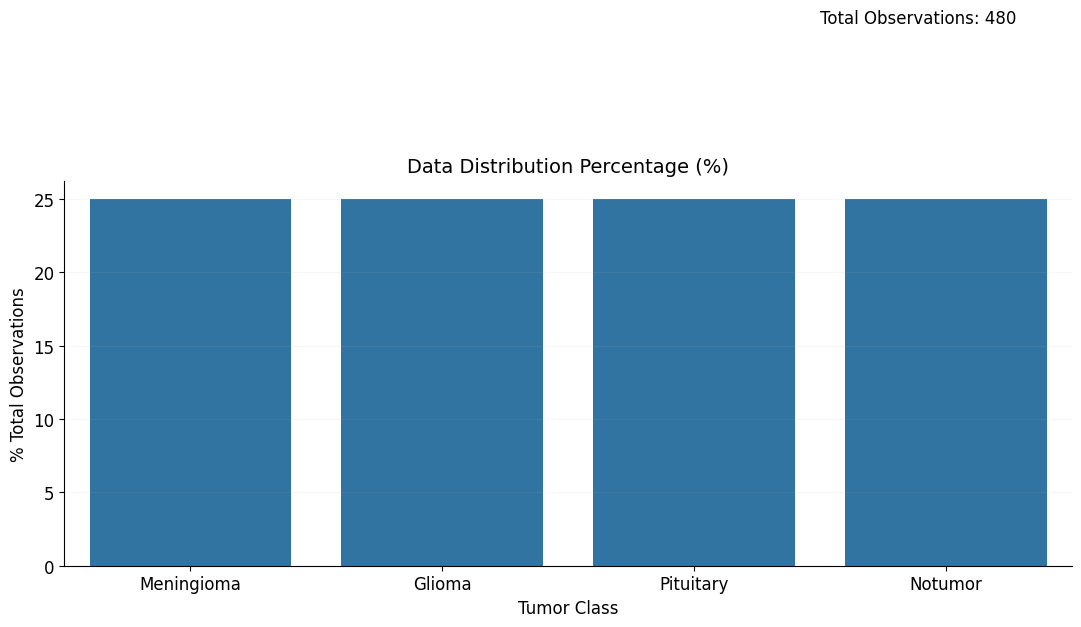

In [ ]:
fig, axis = plt.subplots(figsize=(13, 5))
axis.grid(True, alpha=0.1)
axis.set_title("Data Distribution Percentage (%)", fontsize=14)
sns.barplot(x=['\n'.join(curr_index.strip().split('_')).title() for curr_index in data_distribution_count.index],
            y=100 * data_distribution_count / data_distribution_count.sum(), ax=axis)
axis.set_xlabel("Tumor Class", fontsize=12)
axis.set_ylabel("% Total Observations", fontsize=12)
axis.tick_params(which='major', labelsize=12)
axis.text(2.5, 37, f'Total Observations: {data_distribution_count.sum()}', fontdict=dict(size=12))
sns.despine()

# Preprocess Data


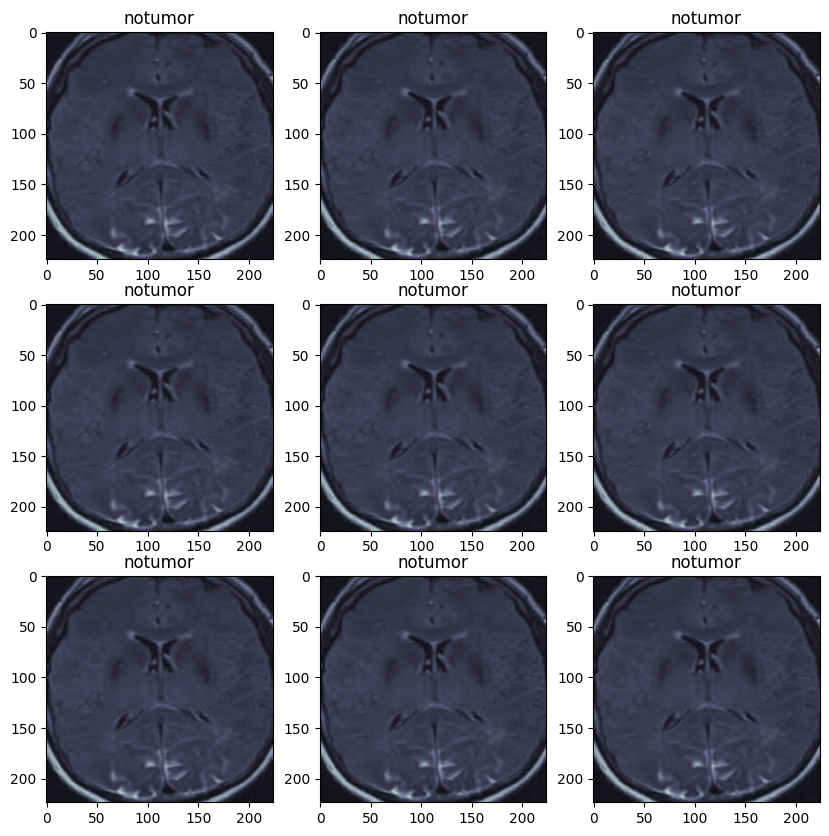

In [ ]:
from tqdm import tqdm
import cv2
import imutils

def crop_img(img):

  # Find extreme points on the image and crop the rectangular out

  gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3, 3), 0)

  # threshold the image, then perform a series of erosions +
  # dilations to remove any small regions of noise
  thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
  thresh = cv2.erode(thresh, None, iterations=2)
  thresh = cv2.dilate(thresh, None, iterations=2)

  # find contours in thresholded image, then grab the largest one
  cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  c = max(cnts, key=cv2.contourArea)

  # find the extreme points
  extLeft = tuple(c[c[:, :, 0].argmin()][0])
  extRight = tuple(c[c[:, :, 0].argmax()][0])
  extTop = tuple(c[c[:, :, 1].argmin()][0])
  extBot = tuple(c[c[:, :, 1].argmax()][0])
  ADD_PIXELS = 0
  new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

  return new_img

def preprocess_images(directory):
    for dir in os.listdir(directory):
        path = os.path.join(directory, dir)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            img = cv2.imread(img_path)
            cropped_img = crop_img(img)
            processed_img = cv2.cvtColor(cropped_img, cv2.COLOR_RGB2GRAY)
            processed_img = cv2.bilateralFilter(processed_img, 2, 50, 50)
            processed_img = cv2.applyColorMap(processed_img, cv2.COLORMAP_BONE)
            processed_img = cv2.resize(processed_img, (224, 224))
            cv2.imwrite(img_path, processed_img)


# Preprocess the images before generating data
preprocess_images(dir)

# Display 9 image using matplotlib
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    for curr_index in os.listdir(dir):
        path = os.path.join(dir, curr_index)
        for img_name in os.listdir(path):
            img_path = os.path.join(path, img_name)
            image = plt.imread(img_path)
            plt.imshow(image)
            plt.title(curr_index)
            break
        break


## Splitting the data

In [ ]:
classes = os.listdir(dir)

batch_size = 10

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    validation_split=0.2)

validation_datagen = ImageDataGenerator(rescale=1. / 255,
                                        validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    subset='training'
)

test_generator = validation_datagen.flow_from_directory(
    dir,
    target_size=(224, 224),
    batch_size=batch_size,
    seed=42,
    shuffle = False,
    subset='validation')


print(test_generator.class_indices)


Found 384 images belonging to 4 classes.
Found 96 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}


# Model Training

In [ ]:
!pip install tensorflow-addons optuna


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 24.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


87910968/87910968 [==============================] - 3s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 111, 111, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 111, 111, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

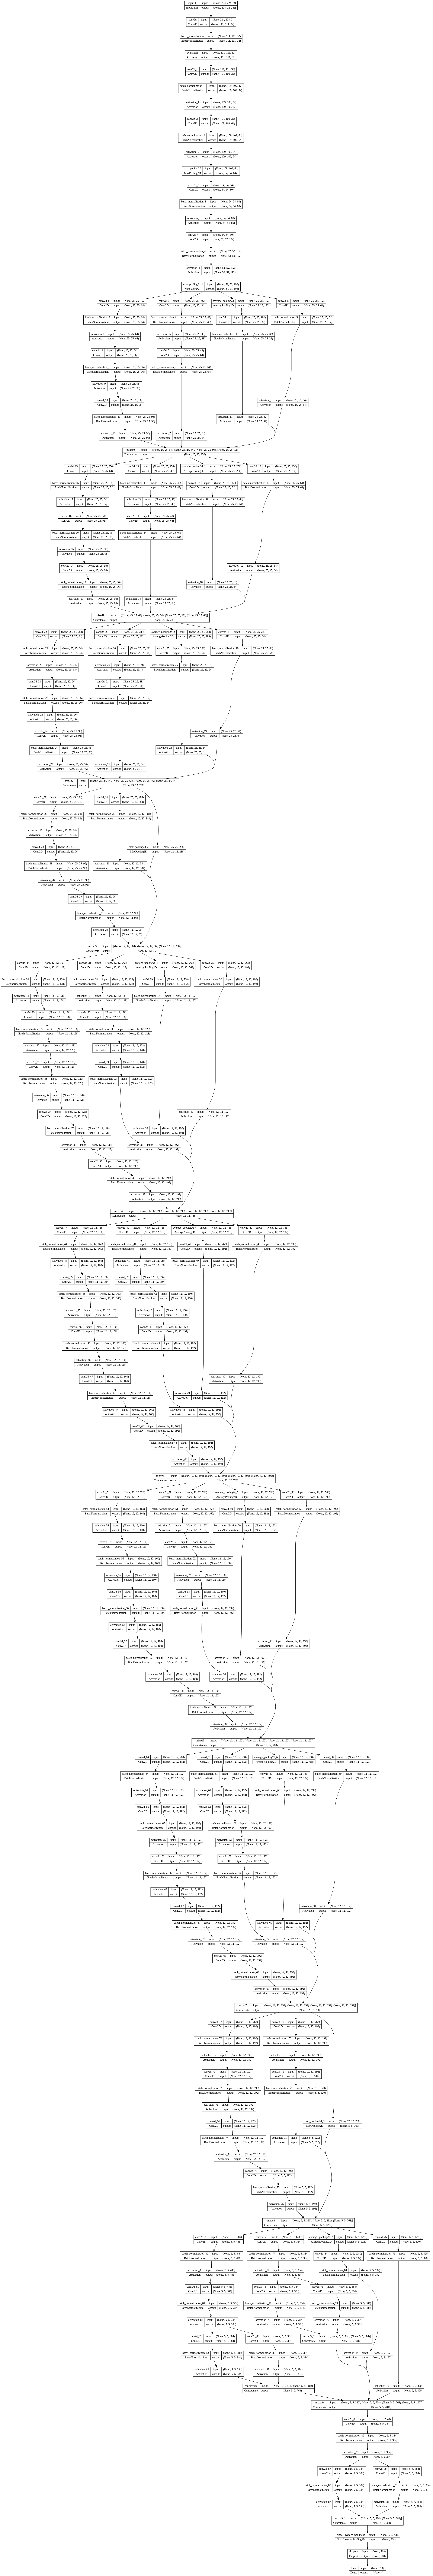

In [ ]:
from keras.applications import InceptionV3
from tensorflow_addons.optimizers import RectifiedAdam
from keras.models import Model
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
import tensorflow as tf

# Load the InceptionV3 model, include the top layers
base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))

# Exclude the bottom three layers (remove last 3 layers)
base_model_layers = base_model.layers[:-3]

# Create a new model with the remaining layers
x = base_model_layers[-1].output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.055)(x)

# Final dense layer with 4 neurons for classification
predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)

# Construct the final model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model with RectifiedAdam optimizer
optimizer = RectifiedAdam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])


# Summary of the model
model.summary()
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
from keras.callbacks import *

reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6)
checkpoint = ModelCheckpoint(model_file, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=20, verbose=1, mode='auto')

# Fit the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=100,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)


Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 2.1755 - accuracy: 0.2968 - precision_1: 0.5000 - recall_1: 0.0080 - categorical_accuracy: 0.2968
Epoch 1: val_loss improved from inf to 2.25438, saving model to ./models/inception.keras
38/38 [==============================] - 35s 334ms/step - loss: 2.1755 - accuracy: 0.2968 - precision_1: 0.5000 - recall_1: 0.0080 - categorical_accuracy: 0.2968 - val_loss: 2.2544 - val_accuracy: 0.2667 - val_precision_1: 0.2917 - val_recall_1: 0.0778 - val_categorical_accuracy: 0.2667 - lr: 1.0000e-04
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 2.0383 - accuracy: 0.4492 - precision_1: 0.7826 - recall_1: 0.0481 - categorical_accuracy: 0.4492
Epoch 2: val_loss improved from 2.25438 to 2.04148, saving model to ./models/inception.keras
38/38 [==============================] - 7s 177ms/step - loss: 2.0383 - accuracy: 0.4492 - precision_1: 0.7826 - recall_1: 0.0481 - categorical_accuracy: 0.4492 - val_loss: 2.0415

# Testing the Model

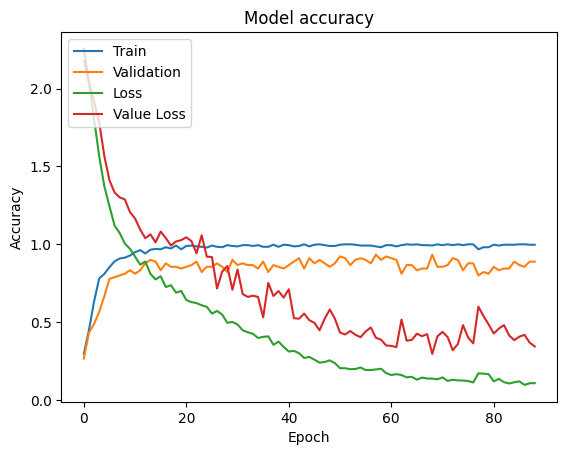

In [ ]:
# Learning curve
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation','Loss', 'Value Loss'], loc='upper left')
plt.show()

In [ ]:
!mkdir ./models
!cp drive/MyDrive/inception_final_224.keras ./models/inception.keras

In [ ]:
# Validate the model with test data

model = keras.models.load_model(model_file)
model.evaluate(test_generator)


# Predict and Display image using matplotlib
# plt.figure(figsize=(20, 20))
# for i in range(9):
#     plt.subplot(3, 3, i + 1)
#     for X_batch, Y_batch in test_generator:
#         image = X_batch[0]
#         # Print Class
#         plt.title("Predicted: " + classes[predictions[i]] + "\nActual: " + classes[np.argmax(Y_batch[i])])

#         plt.imshow(image)
#         break


10/10 [==============================] - 8s 194ms/step - loss: 0.3166 - accuracy: 0.9271 - precision_1: 0.9348 - recall_1: 0.8958 - categorical_accuracy: 0.9271


[0.31655409932136536,
 0.9270833134651184,
 0.9347826242446899,
 0.8958333134651184,
 0.9270833134651184]

# Model Visualisation (Evaluation)

10/10 [==============================] - 0s 44ms/step


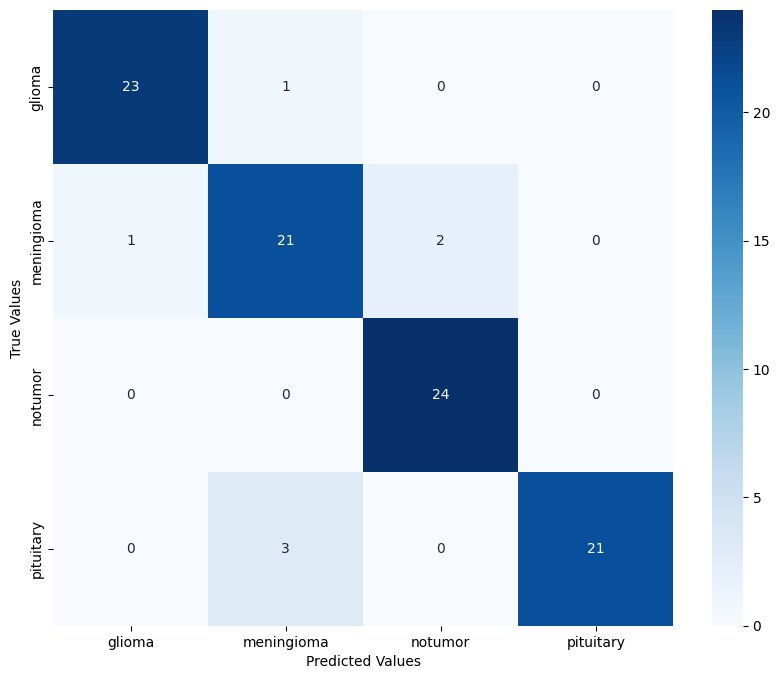

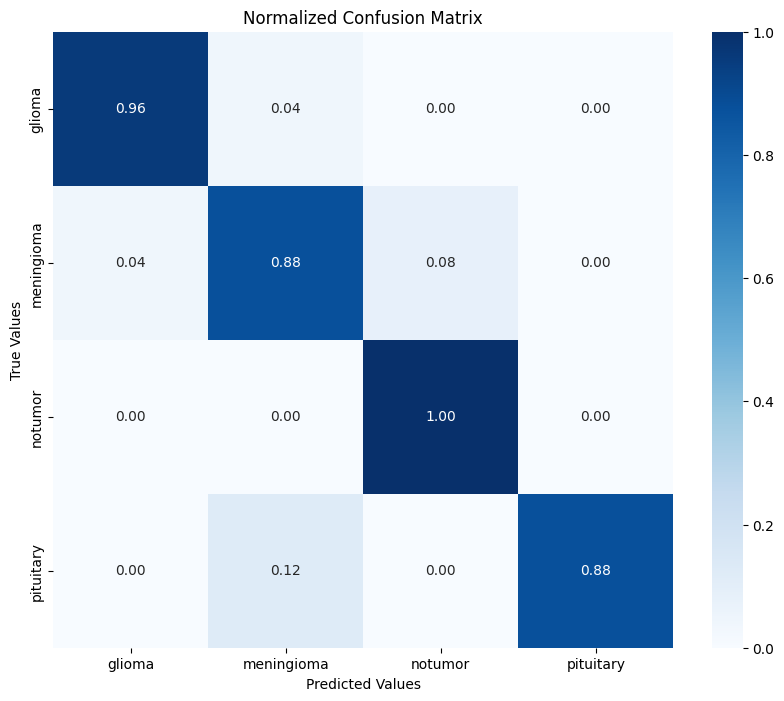

DSC: 0.9272023809523811, Sensitivity: 0.9270833333333334, Specificity: 0.9756944444444444, Accuracy: 0.9270833333333334


In [17]:
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score

# {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
classes = ['glioma', 'meningioma', 'notumor', 'pituitary']

def calculate_metrics(y_true, y_pred):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the Confusion Matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.show()

    # Normalize the confusion matrix
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    # Plot the normalized confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')
    plt.title('Normalized Confusion Matrix')
    plt.show()

    # Calculate metrics for each class and average them
    dsc = np.mean([2.0 * cm[i, i] / (np.sum(cm[i, :]) + np.sum(cm[:, i])) for i in range(cm.shape[0])])
    sensitivity = np.mean([cm[i, i] / np.sum(cm[i, :]) for i in range(cm.shape[0])])
    specificity = np.mean([np.sum(np.delete(np.delete(cm, j, 0), j, 1)) / np.sum(np.delete(cm, j, 0)) for j in range(cm.shape[0])])

    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)

    return dsc, sensitivity, specificity, accuracy

# Predict the output
predictions_prob = model.predict(test_generator)
predictions = np.argmax(predictions_prob, axis=1)

dsc, sensitivity, specificity, accuracy = calculate_metrics(test_generator.classes, predictions)
print(f"DSC: {dsc}, Sensitivity: {sensitivity}, Specificity: {specificity}, Accuracy: {accuracy}")


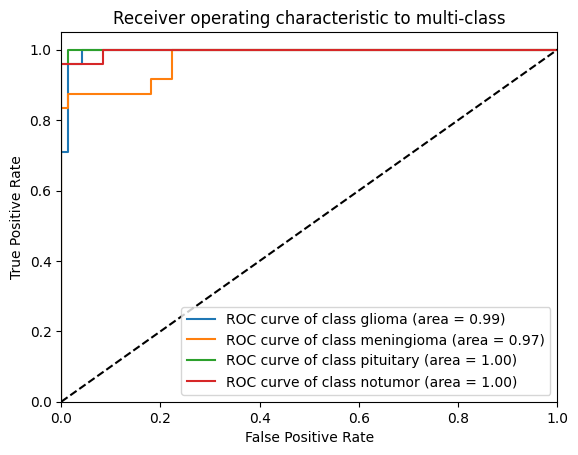

              precision    recall  f1-score   support

      glioma       0.96      0.96      0.96        24
  meningioma       0.84      0.88      0.86        24
   pituitary       0.92      1.00      0.96        24
     notumor       1.00      0.88      0.93        24

   micro avg       0.93      0.93      0.93        96
   macro avg       0.93      0.93      0.93        96
weighted avg       0.93      0.93      0.93        96
 samples avg       0.93      0.93      0.93        96



In [16]:
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
import numpy as np

# Binarize the output
lb = LabelBinarizer()
y_test = lb.fit_transform(test_generator.classes)
y_pred = lb.transform(predictions)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(classes)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], predictions_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot all ROC curves
plt.figure()
for i, class_name in enumerate(classes):
    plt.plot(fpr[i], tpr[i],
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(class_name, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

# Print classification report
print(classification_report(y_test, y_pred, target_names=classes))

# K-Folds Validation

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from tensorflow_addons.optimizers import RectifiedAdam
from keras.applications import InceptionV3
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.layers import GlobalAveragePooling2D, Dense, Dropout
from keras.regularizers import l2
from keras.models import Model

# Set parameters
dir = 'dataset_19'  # Update this to your dataset directory
batch_size = 10
input_shape = (224, 224, 3)
num_classes = 4
initial_learning_rate = 1e-4
k = 5

# Prepare data generators
datagen = ImageDataGenerator(
    rescale=1. / 255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05)

# List all images and labels
all_images = []
all_labels = []

for class_index, class_name in enumerate(os.listdir(dir)):
    class_dir = os.path.join(dir, class_name)
    for image_name in os.listdir(class_dir):
        all_images.append(os.path.join(class_dir, image_name))
        all_labels.append(str(class_index))  # Convert class index to string

# Convert lists to numpy arrays
all_images = np.array(all_images)
all_labels = np.array(all_labels)

# Define K-Fold cross-validation
kf = KFold(n_splits=k, shuffle=True, random_state=42)

# Initialize lists to store metrics
fold_accuracies = []
fold_losses = []

# Iterate over each fold
for fold, (train_index, val_index) in enumerate(kf.split(all_images)):
    print(f'Fold {fold + 1}/{k}')

    train_images, val_images = all_images[train_index], all_images[val_index]
    train_labels, val_labels = all_labels[train_index], all_labels[val_index]

    # Create DataFrames for training and validation data
    train_df = pd.DataFrame({'filename': train_images, 'class': train_labels})
    val_df = pd.DataFrame({'filename': val_images, 'class': val_labels})

    # Create training and validation data generators
    train_generator = datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = datagen.flow_from_dataframe(
        dataframe=val_df,
        x_col='filename',
        y_col='class',
        target_size=(224, 224),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Load the InceptionV3 model, include the top layers
    base_model = InceptionV3(weights='imagenet', include_top=False,input_shape=(224,224,3))

    # Exclude the bottom three layers (remove last 3 layers)
    base_model_layers = base_model.layers[:-3]

    # Create a new model with the remaining layers
    x = base_model_layers[-1].output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.055)(x)

    # Final dense layer with 4 neurons for classification
    predictions = Dense(4, activation='softmax', kernel_regularizer=l2(0.1), dtype='float64')(x)

    # Construct the final model
    model = Model(inputs=base_model.input, outputs=predictions)

    # Compile the model with RectifiedAdam optimizer
    optimizer = RectifiedAdam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), 'categorical_accuracy'])


    # Callbacks
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.3, min_lr=1e-6, verbose=1)
    early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='auto')

    # Train the model
    history = model.fit(
        train_generator,
        steps_per_epoch=train_generator.samples // train_generator.batch_size,
        epochs=90,
        validation_data=validation_generator,
        validation_steps=validation_generator.samples // validation_generator.batch_size,
        callbacks=[early_stopping, reduce_lr]
    )

    # Store the best validation accuracy and loss for the current fold
    best_val_accuracy = max(history.history['val_accuracy'])
    best_val_loss = min(history.history['val_loss'])
    fold_accuracies.append(best_val_accuracy)
    fold_losses.append(best_val_loss)

# Calculate mean and standard deviation of accuracies and losses
mean_accuracy = np.mean(fold_accuracies)
std_accuracy = np.std(fold_accuracies)
mean_loss = np.mean(fold_losses)
std_loss = np.std(fold_losses)

print(f'Validation Accuracy: {mean_accuracy:.4f} ± {std_accuracy:.4f}')
print(f'Validation Loss: {mean_loss:.4f} ± {std_loss:.4f}')


Fold 1/5
Found 384 validated image filenames belonging to 4 classes.
Found 96 validated image filenames belonging to 4 classes.
Epoch 1/90
38/38 [==============================] - 42s 369ms/step - loss: 2.2582 - accuracy: 0.2754 - precision: 0.3542 - recall: 0.0455 - categorical_accuracy: 0.2754 - val_loss: 2.1396 - val_accuracy: 0.4111 - val_precision: 0.4884 - val_recall: 0.2333 - val_categorical_accuracy: 0.4111 - lr: 1.0000e-04
Epoch 2/90
38/38 [==============================] - 9s 226ms/step - loss: 2.1095 - accuracy: 0.3770 - precision: 0.5455 - recall: 0.0481 - categorical_accuracy: 0.3770 - val_loss: 2.1099 - val_accuracy: 0.4222 - val_precision: 0.6154 - val_recall: 0.1778 - val_categorical_accuracy: 0.4222 - lr: 1.0000e-04
Epoch 3/90
38/38 [==============================] - 7s 185ms/step - loss: 1.9132 - accuracy: 0.5294 - precision: 0.8281 - recall: 0.1417 - categorical_accuracy: 0.5294 - val_loss: 1.9934 - val_accuracy: 0.4778 - val_precision: 0.7045 - val_recall: 0.3444 - 

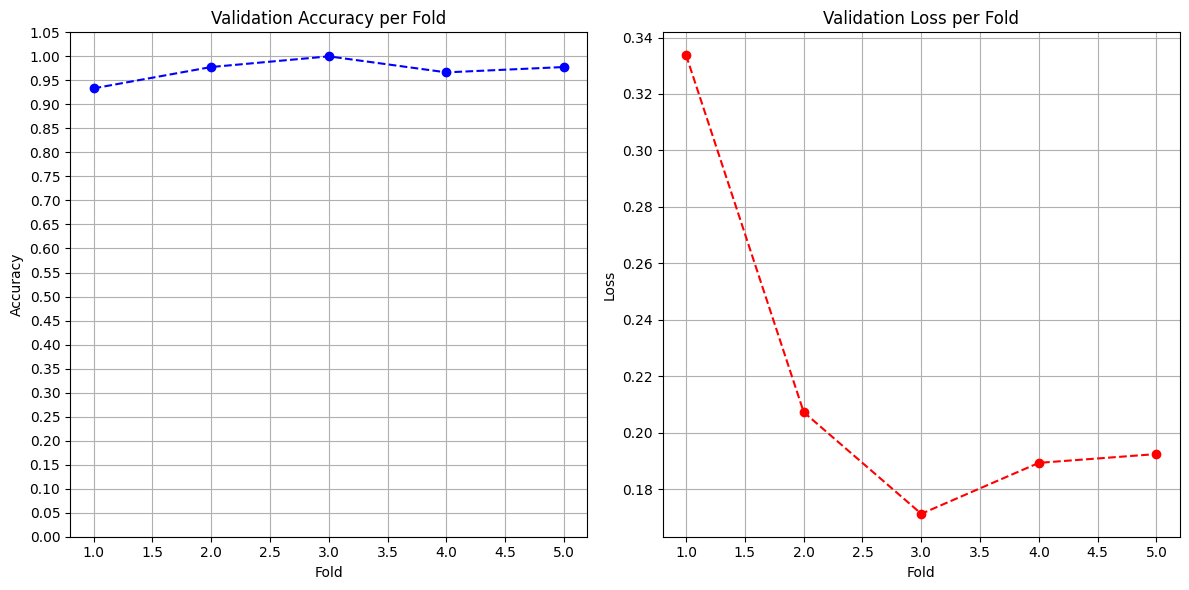

In [ ]:
import matplotlib.pyplot as plt

# Plot validation accuracies
plt.figure(figsize=(12, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(range(1, k + 1), fold_accuracies, marker='o', linestyle='--', color='b')
plt.title('Validation Accuracy per Fold')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.yticks(np.arange(0, 1.1, 0.05))
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, k + 1), fold_losses, marker='o', linestyle='--', color='r')
plt.title('Validation Loss per Fold')
plt.xlabel('Fold')
plt.ylabel('Loss')
plt.grid(True)

# Show plots
plt.tight_layout()
plt.show()